In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer ,ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 1- Make a data set with all emotions

### Merge The two datasets to get neutral emotion 

In [4]:
df1 = pd.read_csv('./First Data/training.csv')
df1.shape

(16000, 2)

In [5]:
df3 = pd.read_csv('./Third Data/tweet_emotions.csv')
df3.shape

(40000, 3)

In [6]:
df3 = df3[df3.sentiment == 'neutral'] 

df3.shape

(8638, 3)

In [7]:
df3=df3[:200]
df3.shape

(200, 3)

In [8]:
df3.head()

,tweet_id,sentiment,content
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
10,1956969456,neutral,cant fall asleep
22,1956972116,neutral,No Topic Maps talks at the Balisage Markup Con...
31,1956975441,neutral,@cynthia_123 i cant sleep
32,1956975860,neutral,I missed the bl***y bus!!!!!!!!


### Drop the id column

In [9]:
df3.drop(['tweet_id'],axis=1,inplace = True)

In [10]:
df3.head()

,sentiment,content
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!


### Rename the coulmns names


In [11]:
df3.rename(
    columns={"sentiment":"label",
                "content":"text",
                   }
          ,inplace=True)
df3.head()

,label,text
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!


### insert value 6 insted of neutral word

In [12]:
df3.label =int(6) 
df3.head()

,label,text
4,6,@dannycastillo We want to trade with someone w...
10,6,cant fall asleep
22,6,No Topic Maps talks at the Balisage Markup Con...
31,6,@cynthia_123 i cant sleep
32,6,I missed the bl***y bus!!!!!!!!


### Concat the two datasets

In [13]:
df = pd.concat([df1, df3], ignore_index = True, axis = 0)
df.shape

(16200, 2)

### shuffle the data set 

In [14]:
df=df.sample(frac = 1)

In [15]:
df.head()
#label_dict = {0:'sad', 1:'happy', 2:'love', 3:'angry', 4:'fear', 5:'surprise',6:'neutral'}


,text,label
8387,i didnt really feel sympathetic for him they w...,2
9852,i always had to eat everything on my plate and...,1
6083,i feel like my bones broke but when i stood up...,0
8111,i was experiencing a ton of pain in my leg mus...,0
4379,i asked feeling smug,1


### drop the fear and surprise emotions

In [16]:
df = df[df.label != 4] #& 'boredom' & 'enthusiasm' & 'empty'
df = df[df.label != 5]

df = df[df.label != 'sentiment']
df.head()

/home/paula/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,text,label
8387,i didnt really feel sympathetic for him they w...,2
9852,i always had to eat everything on my plate and...,1
6083,i feel like my bones broke but when i stood up...,0
8111,i was experiencing a ton of pain in my leg mus...,0
4379,i asked feeling smug,1


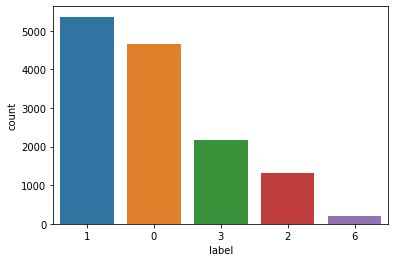

In [17]:
#label_dict = {0:'sad', 1:'happy', 2:'love', 3:'angry',6:'neutral'}

sns.countplot(df['label'],order = df['label'].value_counts(normalize=True).index)

# Data Preprocessing

1- clean any HTML tags in the text

In [18]:
def clean_html(text):
    
    clean = re.compile('<.*?>')
    return re.sub(clean, '',text)
    
df['text']=df['text'].apply(clean_html)
df.head()

,text,label
8387,i didnt really feel sympathetic for him they w...,2
9852,i always had to eat everything on my plate and...,1
6083,i feel like my bones broke but when i stood up...,0
8111,i was experiencing a ton of pain in my leg mus...,0
4379,i asked feeling smug,1


2- convert all the text into lower case 

In [19]:
def convert_lower(text):
    return text.lower()

df['text']=df['text'].apply(convert_lower)
df.head()

,text,label
8387,i didnt really feel sympathetic for him they w...,2
9852,i always had to eat everything on my plate and...,1
6083,i feel like my bones broke but when i stood up...,0
8111,i was experiencing a ton of pain in my leg mus...,0
4379,i asked feeling smug,1


3- clean the Tag sign and Tag name (ex:@Paula)

In [20]:
def cleaning_tags(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)"," ", text).split())

df['text'] = df['text'].apply(lambda x: cleaning_tags(x))
df['text'].head()

8387    i didnt really feel sympathetic for him they w...
9852    i always had to eat everything on my plate and...
6083    i feel like my bones broke but when i stood up...
8111    i was experiencing a ton of pain in my leg mus...
4379                                 i asked feeling smug
Name: text, dtype: object

4- clean all the punctuations  

In [21]:

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].head()

8387    i didnt really feel sympathetic for him they w...
9852    i always had to eat everything on my plate and...
6083    i feel like my bones broke but when i stood up...
8111    i was experiencing a ton of pain in my leg mus...
4379                                 i asked feeling smug
Name: text, dtype: object

In [22]:
#def cleaning_repeating_char(text):
 #   return re.sub(r'([a-z])\1+', r'\1', text)
#df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
#df['text'].head()

5- clean the urls founded in the tweets


In [23]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].head()

8387    i didnt really feel sympathetic for him they w...
9852    i always had to eat everything on my plate and...
6083    i feel like my bones broke but when i stood up...
8111    i was experiencing a ton of pain in my leg mus...
4379                                 i asked feeling smug
Name: text, dtype: object

6- clean all numbers 

In [24]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].head()

8387    i didnt really feel sympathetic for him they w...
9852    i always had to eat everything on my plate and...
6083    i feel like my bones broke but when i stood up...
8111    i was experiencing a ton of pain in my leg mus...
4379                                 i asked feeling smug
Name: text, dtype: object

7-remove stopwords from data

In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

[nltk_data] Downloading package stopwords to /home/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
8387,didnt really feel sympathetic way nominees,2
9852,always eat everything plate ate ate ate withou...,1
6083,feel like bones broke stood still walk,0
8111,experiencing ton pain leg muscles feeling hope...,0
4379,asked feeling smug,1


8- stemming words in data

In [26]:
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()
y=[]

def stem_words(text):
    for i in text:
        y.append(ps.stem(i))
    z=y[:]
    y.clear()
    return z
df['text']=df['text'].apply(stem_words)
df.head()

,text,label
8387,"[d, i, d, n, t, , r, e, a, l, l, y, , f, e, ...",2
9852,"[a, l, w, a, y, s, , e, a, t, , e, v, e, r, ...",1
6083,"[f, e, e, l, , l, i, k, e, , b, o, n, e, s, ...",0
8111,"[e, x, p, e, r, i, e, n, c, i, n, g, , t, o, ...",0
4379,"[a, s, k, e, d, , f, e, e, l, i, n, g, , s, ...",1


9- join back after stemming

In [27]:
def joinback2(list_input):
    return "".join(list_input)
    


df['text']=df['text'].apply(joinback2)
df.head()



,text,label
8387,didnt really feel sympathetic way nominees,2
9852,always eat everything plate ate ate ate withou...,1
6083,feel like bones broke stood still walk,0
8111,experiencing ton pain leg muscles feeling hope...,0
4379,asked feeling smug,1


### Exploratory data analysis 

1- Sad Emotion

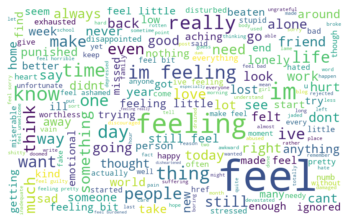

In [28]:
txt = ' '.join(text for text in df[df['label']==0]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

2- Happy Emotion

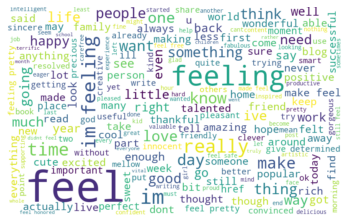

In [29]:
txt = ' '.join(text for text in df[df['label']==1]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

3- Love Emotion

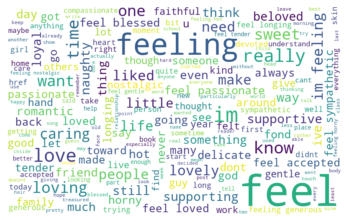

In [30]:
txt = ' '.join(text for text in df[df['label']==2]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

4-Angry Emotion

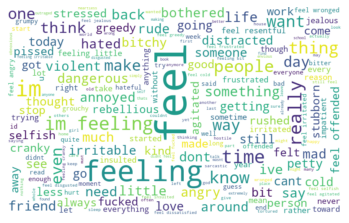

In [31]:
txt = ' '.join(text for text in df[df['label']==3]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

5- Neutral Emotion

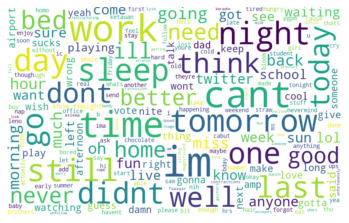

In [32]:
txt = ' '.join(text for text in df[df['label']==6]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### split data 

In [33]:
X=df['text']
y=df.label
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3) 

### Transfer data into numerical features using TFIDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(binary=True, use_idf=True)
X_train = vec.fit_transform(X_train) 
X_test = vec.transform(X_test)

In [35]:
X_test.shape

(4108, 11573)

### Try first model passive aggressive classfier

In [36]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [37]:
y_pred=pac.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 89.85%


### Try second model : logistic regression

In [38]:
log_reg = LogisticRegression(max_iter=50).fit(X_train, y_train)


/home/paula/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
y_predicted = log_reg.predict(X_test)
score=accuracy_score(y_test,y_predicted)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 88.32%


### Try third model : xgboost 

In [40]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100,learning_rate=0.2)

In [41]:
model.fit(X_train, y_train)


[21:46:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [42]:
y_pred = model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 89.68%


### Testing

In [48]:

Lines=["Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"]
#Lines = cv.transform(Lines)
Lines =vec.transform(Lines)
scores = pac.predict(Lines)  
#Prob score for both classes (Good/bad) 
score = scores[0]
if score == 0:
    print('The post is sad')
elif score ==1:
    print('The post is happy')
elif score == 2:
     print('The post is Love')
elif score == 3 :
    print('The post is anger')

elif score == 6 :
    print('the post is Neutral ')

the post is Neutral 
